This Notebook will find optimal wieghts using MPT, then will back test those wieghts 1 year fowrad from data collections

In [1]:
import time
import os 

start_time = time.time() # measure run time

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
print(f'Current Working Directory: {os.getcwd()}')


Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py


Get Back Test Dates

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from utils.config import PROGRAM_START_DATE, PROGRAM_END_DATE, mpt_stocks_for_profit, mpt_stocks_for_sharpe
from utils.finance_utils import backtest_portfolio, MPTOptimizer

date_obj = datetime.strptime(PROGRAM_END_DATE, "%Y-%m-%d")  # Convert string to datetime objectb
backtest_end = date_obj + relativedelta(years=1)

backtest_start = PROGRAM_END_DATE


Updated on 02/05/2025 12:55

---------------------------------
finance_utils.py successfully loaded, updated last Feb. 07 2025 12.04
---------------------------------




Conduct MPT

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


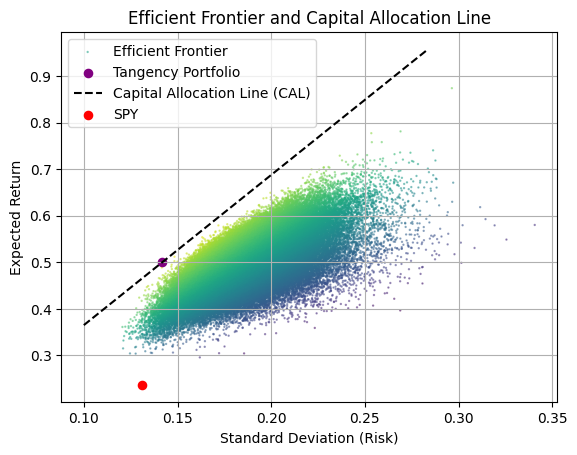

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 3.23
Corresponding Return: 0.5
Corresponding Standard Deviation: 0.14
Optimal Weights: {'MPLX': np.float64(0.06996056595787416), 'PDD': np.float64(0.06951843023742875), 'MAR': np.float64(0.0020080931422234226), 'HLT': np.float64(0.2759545722296674), 'META': np.float64(0.5308649811750094), 'ANET': np.float64(0.012233985353480952), 'MSFT': np.float64(0.021791869590092872), 'UNP': np.float64(0.017667502314223295)}


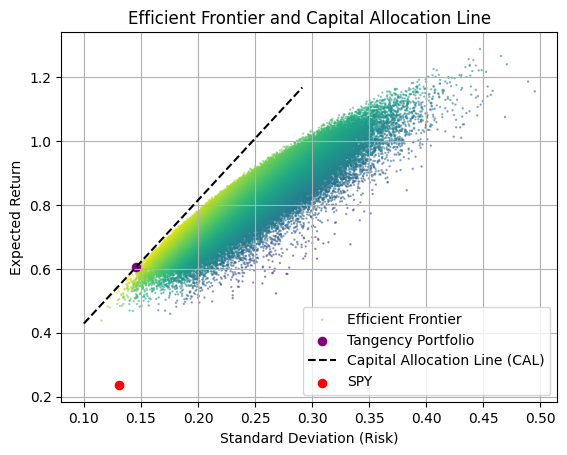

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 3.86
Corresponding Return: 0.61
Corresponding Standard Deviation: 0.15
Optimal Weights: {'APP': np.float64(0.035662288512548955), 'PDD': np.float64(0.03384582754026813), 'MPLX': np.float64(0.03549348782603019), 'BKNG': np.float64(0.2476074509411516), 'META': np.float64(0.16980982382242263), 'FICO': np.float64(0.14679562357968418), 'COIN': np.float64(0.3235741603258409), 'LLY': np.float64(0.007211337452053476)}


In [3]:
optimizer_for_high_profit = MPTOptimizer(mpt_stocks_for_profit, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_profit.simulate_portfolios()
optimizer_for_high_profit.plot_efficient_frontier()
optimal_profit_weights = optimizer_for_high_profit.find_optimal_weights()

optimizer_for_high_sharpe = MPTOptimizer(mpt_stocks_for_sharpe, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_sharpe.simulate_portfolios()
optimizer_for_high_sharpe.plot_efficient_frontier()
optimal_sharpe_weights = optimizer_for_high_sharpe.find_optimal_weights()

Begin Back Testing

In [7]:
optimizer_for_high_profit.spy_return
optimizer_for_high_profit.spy_std

Ticker
SPY    0.13081
dtype: float64

In [4]:
print('----Begining Back Test----')
print(f'Back Test starts on: {backtest_start}')
print(f'Back Test ends on: {backtest_end}')

paper_value = 100_000


weights_for_profit = list(optimal_profit_weights.values())

# Run the backtest
print('\nBack Test on High Profitable Stocks')
backtest_on_high_profit = backtest_portfolio(mpt_stocks_for_profit, paper_value, weights_for_profit, start_date=backtest_start, end_date=backtest_end)
print(f'Ending Value: {round(backtest_on_high_profit, 2)}')

print('\nBack Test on High Sharpe Stocks')
backtest_on_high_sharpe = backtest_portfolio(mpt_stocks_for_sharpe, paper_value, weights_for_profit, start_date=backtest_start, end_date=backtest_end)
print(f'Ending Value: {round(backtest_on_high_sharpe, 2)}')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

----Begining Back Test----
Back Test starts on: 2024-01-01
Back Test ends on: 2025-01-01 00:00:00

Back Test on High Profitable Stocks



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ending Value: 148116.63

Back Test on High Sharpe Stocks


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Ending Value: 200368.35


Record Results

In [5]:
import pandas as pd
import os

# Define file path
file_path = f"{WORKSPACE_DIR}/portfolio_py/data/clean/backtest_results.csv"

# Check if file exists
if os.path.exists(file_path):
    # Load existing data
    backtest_df = pd.read_csv(file_path)
else:
    # Create a new DataFrame if the file doesn't exist
    backtest_df = pd.DataFrame(columns=[
        "Data_Collection_Start", "Data_Collection_End",
        "Backtest_Start", "Backtest_End",
        "Stock_Selection_Method", 'Stocks',"Starting_Value", "Ending_Value"
    ])

# New entries to append
new_entries = [
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Profit Stocks",
        "Stocks": (",".join(mpt_stocks_for_profit)),
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_profit
    },
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Sharpe Ratio Stocks",
        "Stocks": (",".join(mpt_stocks_for_sharpe)),
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_sharpe
    }
]

# Convert new entries to a DataFrame
new_entries_df = pd.DataFrame(new_entries)

# Drop duplicates before writing
backtest_df = pd.concat([backtest_df, new_entries_df], ignore_index=True).drop_duplicates()

# **Append** to the CSV without overwriting
backtest_df.to_csv(file_path, index=False, mode="w")  

print("New rows added successfully (without overwriting)!") 


New rows added successfully (without overwriting)!


Possibly implemnt affects of leverage

### Portfolio Return and Volatility with Risk-Free Asset

1. **Portfolio Return:**
   $$
   R_p = w_r \cdot R_{\text{risky}} + (1 - w_r) \cdot R_f
   $$
   Where:
   - R_p = Portfolio return
   - w_r = Weight of the risky portfolio
   - R_{\text{risky}} = Return of the risky portfolio
   - R_f = Risk-free rate



2. **Portfolio Volatility:**
   $$
   \sigma_p = w_r \cdot \sigma_{\text{risky}}
   $$
   Where:
   - \sigma_p = Portfolio standard deviation (volatility)
   - w_r = Weight of the risky portfolio
   - \sigma_{\text{risky}} = Standard deviation of the risky portfolio


Find benchamrk log returns, and std, and then create a portfolio where std is below benchmark, but return is greater than

Also possibly put in a bell curve of distrubution of losses, and confidence intervals